In [154]:
!git clone https://github.com/Etienne-bdt/BEI-SIA25
!unzip /content/BEI-SIA25/data.zip -d /content/BEI-SIA25/

fatal: destination path 'BEI-SIA25' already exists and is not an empty directory.
Archive:  /content/BEI-SIA25/data.zip
replace /content/BEI-SIA25/data/31000/patches/192_192_after.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
import sys
sys.path.append("/content/BEI-SIA25")

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils.dataloader import CadastreSen2Dataset
from utils.index_calculation import BSI, NDBI, NDMI, NDVI, NDWI

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data

Get the data

Prepare pytorch dataset

In [4]:
dataset = CadastreSen2Dataset(image_path="/content/BEI-SIA25/data/")

Prepare dataloader

In [5]:
batch_size = 4
num_threads = 0

#Split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# Model definition

In [6]:
class Conv2DRegressionModel(nn.Module):
    def __init__(self, int_channels: int = 11):
        super(Conv2DRegressionModel, self).__init__()
        self.nb_channel = int_channels
        self.enc1 = nn.Sequential(
            nn.Conv2d(int_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        y = self.enc1(X)
        enc1_out = y
        y = self.enc2(y)
        enc2_out = y
        y = self.enc3(y)
        enc3_out = y
        y = self.enc4(y)
        y = self.dec4(y)
        y = torch.cat((y, enc3_out), dim=1)
        y = self.dec3(y)
        y = torch.cat((y, enc2_out), dim=1)
        y = self.dec2(y)
        y = torch.cat((y, enc1_out), dim=1)
        y = self.dec1(y)
        return y

class DiffusionModel(nn.Module):
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alpha_cumprod[:-1]]).to(device)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod).to(device)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod).to(device)
        self.posterior_variance = self.beta * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)

        self.model = nn.Sequential(
            nn.Conv2d(11, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x, mask, t):
        noise = torch.randn_like(x).to(device)
        x_t = self.sqrt_alpha_cumprod[t] * x + self.sqrt_one_minus_alpha_cumprod[t] * noise
        return self.model(torch.cat((x_t * (1 - mask), mask), dim=1))

    def p_losses(self, x_start, mask, t):
        noise = torch.randn_like(x_start)
        x_noisy = self.sqrt_alpha_cumprod[t] * x_start + self.sqrt_one_minus_alpha_cumprod[t] * noise
        predicted_noise = self.forward(x_noisy, mask, t)
        return nn.MSELoss()(predicted_noise, noise)

    def sample(self, x, mask):
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.tensor([t]).to(device)
            predicted_noise = self.forward(x, mask, t_tensor)
            if t > 0:
                noise = torch.randn_like(x)
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t]) + torch.sqrt(self.posterior_variance[t]) * noise
            else:
                x = (x - (1 - self.alpha[t]) / torch.sqrt(1 - self.alpha_cumprod[t]) * predicted_noise) / torch.sqrt(self.alpha[t])
        return x

# Train the model

In [ ]:
import ignite.metrics as im

In [7]:
n_epochs = 50
learning_rate = 0.001

model = DiffusionModel()
model = model.to(device)


# metric = im.SSIM(data_range=1.0)
# metric.attach(im.default_evaluator, 'ssim')
# preds = torch.rand([4, 3, 16, 16])
# target = preds * 0.75
# state = im.default_evaluator.run([[preds, target]])
# print(state.metrics['ssim'])

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(val_loader)

train_loss_comp, val_loss_comp = [], []
train_loss_pred, val_loss_pred = [], []
train_loss_comp_pred, val_loss_comp_pred = [], []
train_loss_tot, val_loss_tot = [], []
train_loss_visu, val_loss_visu = [], []
best_loss=1000000
for epoch in tqdm(range(n_epochs)):
    model.train()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0

    for x, y, mask in train_loader:
        x,y,mask = x.to(device), y.to(device), mask.to(device)
        x,y,mask = x.float(), y.float(), mask.float()
        optimizer.zero_grad()
        # img_2018, img_2024 = img_2018.to(device), img_2024.to(device)
        # Forward pass

        y = (y-torch.mean(y, axis=(0,1))/torch.std(y, axis=(0,1)))*torch.std(x, axis=(0,1))+torch.mean(x, axis=(0,1))
        y_pred = model.sample(x,mask) # image 2024 prédite à partir de 2018
        Ind_comp = NDVI(y_pred)
        Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
        Ind_real = y[:,5:,:,:]
        Ind_pred = y_pred[:,5:,:,:]
        weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device) # pondération à ajuster
        visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:]) # loss globale
        loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real)) # comparaison des indices calculés
        loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real)) # comparaison des indices prédits
        loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred)) # comparaison des indices calculés et prédits
        total_loss = visual_loss + loss_comp + loss_pred + loss_comp_pred

        accu_visual += visual_loss.item()
        accu_comp += loss_comp.item()
        accu_pred += loss_pred.item()
        accu_comp_pred += loss_comp_pred.item()
        accu_total += total_loss.item()
        # Backward pass
        total_loss.backward()
        optimizer.step()

    train_loss_visu.append(accu_visual/val_set_len)
    train_loss_comp.append(accu_comp / train_set_len)
    train_loss_pred.append(accu_pred / train_set_len)
    train_loss_comp_pred.append(accu_comp_pred / train_set_len)
    train_loss_tot.append(accu_total / train_set_len)
    # Validation - no gradient & eval mode
    model.eval()
    accu_visual = 0.0
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0

    with torch.no_grad():
        for x, y, mask in val_loader:
            x,y,mask = x.to(device), y.to(device), mask.to(device)
            x,y,mask = x.float(), y.float(), mask.float()
            y = (y-torch.mean(y, axis=(0,1))/torch.std(y, axis=(0,1)))*torch.std(x, axis=(0,1))+torch.mean(x, axis=(0,1))
            y_pred = model.sample(x,mask)
            Ind_comp = NDVI(y_pred)
            Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
            Ind_real = y[:,5:,:,:]
            Ind_pred = y_pred[:,5:,:,:]
            weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device)
            visual_loss = loss_fn(y_pred[:,0:3,:,:], y_pred[:,0:3,:,:])
            loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real))
            loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real))
            loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred))
            total_loss = visual_loss + loss_comp + loss_pred + loss_comp_pred

            accu_visual += visual_loss.item()
            accu_comp += loss_comp.item()
            accu_pred += loss_pred.item()
            accu_comp_pred += loss_comp_pred.item()
            accu_total += total_loss.item()

    val_loss_visu.append(accu_visual/val_set_len)
    val_loss_comp.append(accu_comp / val_set_len)
    val_loss_pred.append(accu_pred / val_set_len)
    val_loss_comp_pred.append(accu_comp_pred / val_set_len)
    val_loss_tot.append(accu_total / val_set_len)

    if accu_total < best_loss:
        best_loss = accu_total
        torch.save(model.state_dict(), "best_model.pt")

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Train loss: {train_loss_tot[-1]:.4f} - Val loss: {val_loss_tot[-1]:.4f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch}.pt")


  2%|▏         | 1/50 [00:47<38:46, 47.48s/it]

Epoch 1/50 - Train loss: 20868534.4226 - Val loss: 2387120.9167


  4%|▍         | 2/50 [01:32<36:53, 46.12s/it]

Epoch 2/50 - Train loss: 1646125.7857 - Val loss: 1091827.1146


  6%|▌         | 3/50 [02:17<35:50, 45.76s/it]

Epoch 3/50 - Train loss: 1040057.6518 - Val loss: 870722.1667


  8%|▊         | 4/50 [03:03<34:53, 45.50s/it]

Epoch 4/50 - Train loss: 864700.5863 - Val loss: 778881.8854


 10%|█         | 5/50 [03:47<33:51, 45.14s/it]

Epoch 5/50 - Train loss: 833119.0506 - Val loss: 746594.4531


 12%|█▏        | 6/50 [04:32<33:05, 45.12s/it]

Epoch 6/50 - Train loss: 757617.6071 - Val loss: 644999.7500


 12%|█▏        | 6/50 [04:35<33:37, 45.85s/it]


KeyboardInterrupt: 

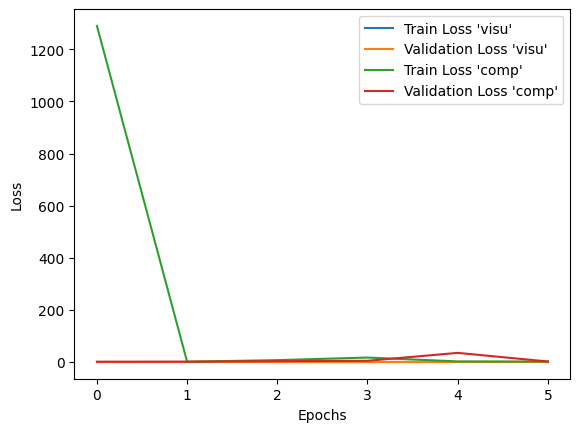

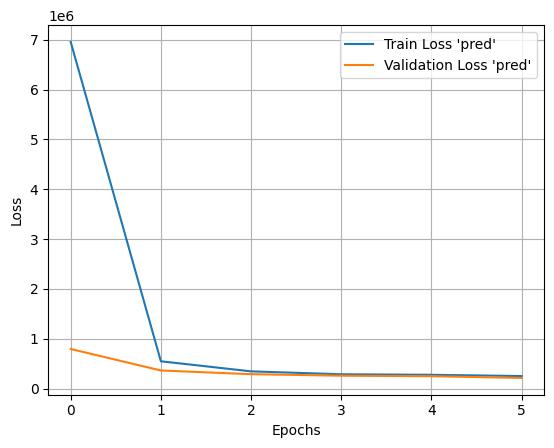

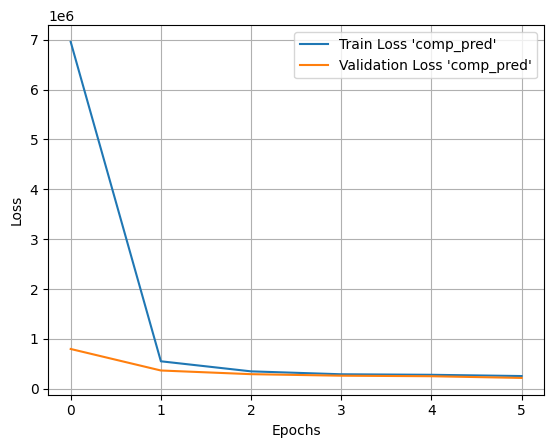

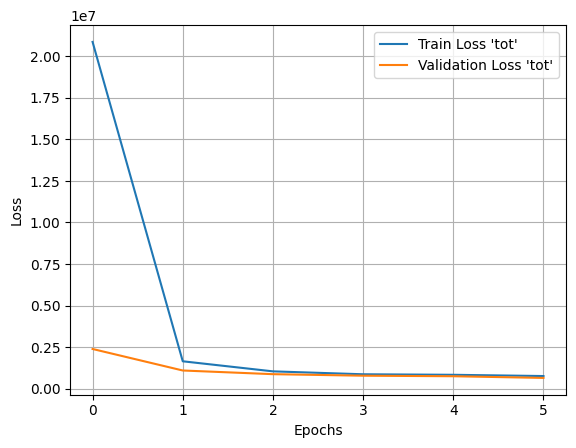

In [12]:
plt.plot(train_loss_visu, label="Train Loss 'visu'")
plt.plot(val_loss_visu, label="Validation Loss 'visu'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


plt.plot(train_loss_comp, label="Train Loss 'comp'")
plt.plot(val_loss_comp, label="Validation Loss 'comp'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_pred, label="Train Loss 'pred'")
plt.plot(val_loss_pred, label="Validation Loss 'pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_comp_pred, label="Train Loss 'comp_pred'")
plt.plot(val_loss_comp_pred, label="Validation Loss 'comp_pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_tot, label="Train Loss 'tot'")
plt.plot(val_loss_tot, label="Validation Loss 'tot'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()


In [11]:
model.to(device)

x,y,mask = next(iter(val_loader))
x,y,mask = x.float(), y.float(), mask.float()
x,y,mask = x[0:1,:,:,:], y[0:1,:,:,:], mask[0:1,:,:,:]
x,y,mask = x.to(device), y.to(device), mask.to(device)
y = (y-torch.mean(y, axis=(0,1))/torch.std(y, axis=(0,1)))*torch.std(x, axis=(0,1))+torch.mean(x, axis=(0,1))
y_pred = model.sample(x,mask)
batch_img=6
fig, ax = plt.subplots(6, 4, figsize=(5,10))
ax[0, 0].imshow((x[batch_img, 0:3, :, :]).permute(1,2,0).detach().numpy())
ax[0, 1].imshow(y[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())
ax[0, 2].imshow(y_pred[batch_img, 0:3, :, :].permute(1,2,0).detach().numpy())
ax[0,3].imshow(mask[batch_img,0,:,:].detach().numpy(),cmap="gray")
ax[1, 0].imshow(x[batch_img, 5, :, :].detach().numpy())
ax[1, 1].imshow(y[batch_img, 5, :, :].detach().numpy())
ax[1, 2].imshow(y_pred[batch_img, 5, :, :].detach().numpy())
ax[2, 0].imshow(x[batch_img, 6, :, :].detach().numpy())
ax[2, 1].imshow(y[batch_img, 6, :, :].detach().numpy())
ax[2, 2].imshow(y_pred[batch_img, 6, :, :].detach().numpy())
ax[3, 0].imshow(x[batch_img, 7, :, :].detach().numpy())
ax[3, 1].imshow(y[batch_img, 7, :, :].detach().numpy())
ax[3, 2].imshow(y_pred[batch_img, 7, :, :].detach().numpy())
ax[4, 0].imshow(x[batch_img, 8, :, :].detach().numpy())
ax[4, 1].imshow(y[batch_img, 8, :, :].detach().numpy())
ax[4, 2].imshow(y_pred[batch_img, 8, :, :].detach().numpy())
ax[5, 0].imshow(x[batch_img, 9, :, :].detach().numpy())
ax[5, 1].imshow(y[batch_img, 9, :, :].detach().numpy())
ax[5, 2].imshow(y_pred[batch_img, 9, :, :].detach().numpy())
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 406138 has 14.74 GiB memory in use. Of the allocated memory 14.22 GiB is allocated by PyTorch, and 413.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)